In [ ]:
#TODO: We should go back and alter the initial two notebooks to make them more consistant with the useage here
#TODO: We need to include a intro on how to actually use the code and how to edit it
#TODO: Read through all markups and ensure that the markups are actually usable

#For right now, having the material is more important than the code, but code will be next

In [34]:
using ModelingToolkit, Latexify, DifferentialEquations, Plots, Statistics

In [32]:
#Plotting formatting
using Plots.Measures
using LaTeXStrings, Colors
font_title = Plots.font("Arial", 24)
font_axis = Plots.font("Arial", 12)
font_legend = Plots.font("Arial", 8)
pyplot(titlefont=font_title, guidefont = font_axis, legendfont = font_legend)

Plots.PyPlotBackend()

## Table of contents:

### _**[0] Introduction to RetinalChaos.jl**_

### [1] Methods
#### [1.1] Voltage and Potassium gating components of the model
#### [1.2] Calcium and the Biochemical Reactions of the sAHP
#### [1.3] Acetylcholine Diffusion and Dynamics
#### [1.4] Gaussian White noise and dynamics

### [2] Analyzing Data Output of the model
#### [2.1] Time Scale Analysis
#### [2.2] Fitting Experimental Data (Patch)
#### [2.3] Fitting Experimental Data (Multi-electrode array)
#### [2.4] Fitting Experimental Data (Calcium Imageing) 

### [3] Experiments
#### [3.1] Dual Eye Correlations
#### [3.2] Recapitulations of older papers
#### Dynamical Analysis

# [0.0] Intro to RetinalChaos.jl
- This is the interface I have developed for working with a model of Retinal Waves. My hope is that this can be included in a github repo that will not only help those understand how to use my model, but also how to think about interacting with a scientific programming language like Julia. 
- I have written the model to be not only physiologically relevant to our understanding of the developing retina, but also in a way that aims to be understood by Neuroscientist, Molecular Biologist, Computer Scientist and Mathematician. 
- Likewise I would like to provide transparency into my own model so that it can easily be extended and modified for future works in neuroscience. 
- I have utilized many packages in the making of this model, but most of all I would like to thank Chris Rackauckas for his extensive and impressive work on a DifferentialEquations.jl package. Julia and DifferentialEquations.jl has proven to provide a unique and powerful interface for simulation of my proposed system 

## [0.0.a] Defining a new model (using Modelling Toolkit)
##### While this package model has many aspects, one of my main goals is for this to be opensource and easily extended. I will explain in this section how a new model can be described. Any mathematical notation can easily be described using the interface. I will demonstrate this using a classical Neuronal model the FitzHugh-Nagumo model. Further tutorials can be found in the ModelingToolkit.jl
- 1) Define the parameters, variables, and derivatives
    - Most often this will be a 1st order derivative with respect to time ($\frac{d(x)}{dt}$)
    - Variables must call time as an argument $V(t)$
    - Time must be included as a parameter

In [9]:
@parameters t a b τ I;
#Defining first order derivatives with respect to time
@derivatives d'~ t;
#defining the variables V and W
@variables V(t) W(t);

- 2) Define the equations

In [10]:
eqs = [
    d(V) ~ V - (V^3/3) - W + I
    d(W) ~ (V + a - b*W)/τ
]
latexify(eqs)

L"\begin{align}
\frac{dV(t)}{dt} =& \mathrm{V}\left( t \right) - \frac{\left( \mathrm{V}\left( t \right) \right)^{3}}{3} - \mathrm{W}\left( t \right) + I \\
\frac{dW(t)}{dt} =& \frac{\mathrm{V}\left( t \right) + a - b \mathrm{W}\left( t \right)}{\tau}
\end{align}
"

- 3) Define the initial conditions and parameter values. 
    - In many cases there are alot of parameters, so I use a system of .JSON files for storing these and loading the parameters. I will describe this later

In [11]:
#Define initial conditions
u0 = [V => 0.0, W => 0.0];
#Define parameters
p  = [a => 0.8, b => 0.7, τ => 12.5, I => 0.5];

In [12]:
#Load the system into an ODE system
FH_ode = ODESystem(eqs); #This is all you need for an Ordinary Differential Equation

4) Running the model

In [13]:
tspan = (0.0, 100.0);
prob = ODEProblem(FH_ode, u0, tspan, p);
sol = solve(prob, Tsit5());

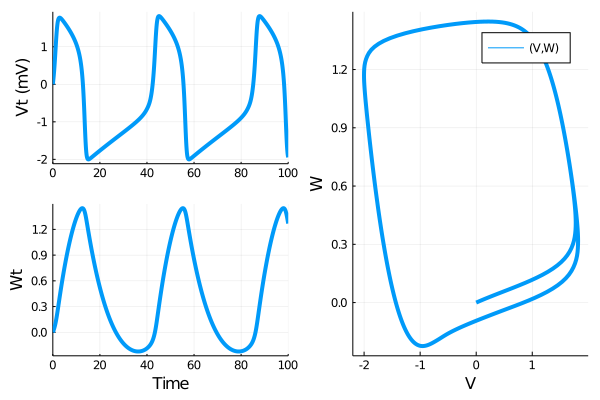

In [14]:
p1 = plot(sol, layout = grid(2,1), ylabel = ["Vt (mV)" :Wt], xlabel = ["" :Time], label = "");
p2 = plot(sol, vars = (:V, :W));
plot(p1, p2, layout = grid(1,2), lw = 4.0)

### We can also define a function using Stochastic differential equations. This will be useful for simulation of noise later

In [15]:
noise = [1.0, 0.0] #We add noise to the first variable (V)
FH_sde = SDESystem(eqs, noise, t, FH_ode.states, FH_ode.ps); #We take the conditions (labeled states) and parameters (labeled ps) from the ODE model

In [16]:
tspan = (0.0, 100.0);
prob = SDEProblem(FH_sde, u0, tspan, p);
SDE_sol = solve(prob, Tsit5());

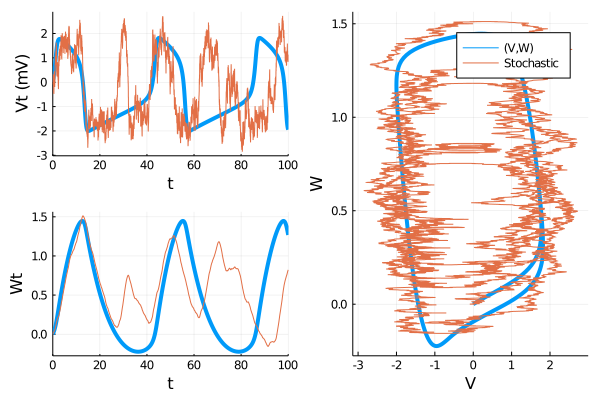

In [17]:
plot!(p1, SDE_sol, layout = grid(2,1), label = "");
plot!(p2, SDE_sol, vars = (:V, :W), label = "Stochastic");
plot(p1, p2, layout = grid(1,2), c = :red)

## [0.0.b] Opening JSON parameter files
- At times writing all parameters will be tedious. We can utilize JSON files. I have included functions for this in the package RetinalChaos.
- write_JSON allows you to export a dictionary or NamedTuple to a JSON file (function works the same way for both NamedTuple and Dictionaries). 
- read_JSON allows you to import a JSON file as a dictionary or NamedTuple (specified in is_type). 
    - the dictionary can be edited on a parameter by parameter basis
- After parameter files are imported:
    - If using a 2D model, extract_dict allows you to format the parameter dictionary into a form the model can use. 
    - If using a 1D model, ModelingToolkit.jl extract_dict takes the dictionary and turns it into the correct format
    - extract_model

In [18]:
using JSON2

In [19]:
function write_JSON(data, name_file)
    string_data = JSON2.write(data)
    open(name_file, "w") do f
        write(f, string_data)
    end
end

function read_JSON(name_file::String; is_type = Dict{Symbol, Float64})
    nt = nothing
    open(name_file, "r") do f
        nt = JSON2.read(f, is_type)
    end
    nt
end

#For models that were defined using the Modeling Toolkit
function extract_dict(dict_item::Dict{Symbol, Float64})
    par_set = nothing
    idx = 1
    for key in keys(dict_item)
        if par_set == nothing
            par_set = [Variable(key) => dict_item[key]]
        else
            push!(par_set, (Variable(key)=> dict_item[key]))
        end
    end
    par_set
end

#For models that weren't defined in the Modeling Toolkit (2D models)
extract_dict(dict_item::Dict{Symbol, Float64}, pars::Array{Symbol}) = map(x -> Float64(dict_item[x]), pars)

extract_dict (generic function with 4 methods)

In [20]:
p_dict = read_JSON("params.json")

Dict{Symbol,Float64} with 32 entries:
  :V1     => -20.0
  :V2     => 20.0
  :E_Ca   => 50.0
  :g_K    => 7.0
  :g_TREK => 2.0
  :g_leak => 2.0
  :τc     => 2000.0
  :α      => 625.0
  :D      => 0.01
  :V4     => 7.0
  :τa     => 8300.0
  :σ      => 0.1
  :V0     => -40.0
  :τACh   => 540.0
  :k_d    => 0.1
  :λ      => 2.702
  :C_m    => 22.0
  :k      => 0.2
  :δ      => 0.010503
  :β      => 34.0
  :g_Ca   => 10.0
  :ρ      => 6.0
  :E_K    => -90.0
  :τb     => 8300.0
  :E_ACh  => 0.0
  ⋮       => ⋮

In [21]:
#Editing a single parameter is as simple as calling the parameter in a dictionary
p_dict[:I_app] = 10.0;

In [22]:
#Converting a dictionary to Modelling Toolkit parameters can be done using a function chain, 
p = p_dict |> extract_dict;
#or function call
p = extract_dict(p_dict);

In [23]:
#Likewise you can import the JSON file directly into the Modelling Toolkit format without editing using the function chaining interface
p = read_JSON("params.json") |> extract_dict;

### [0.0.d] Timestepping and sparse saving
- This section is a quick run through on the minumum functions necessary to run the model. 
- This section also shows different Integration algorithims and how they can efficiently simulate a trajectory. 

In [24]:
using RetinalChaos
import RetinalChaos: read_JSON, extract_dict, SOSRI
import RetinalChaos: T_sde
import RetinalChaos: SDEProblem, solve

In [41]:
#For a single Noisy trajector, this is how we can open and run the simulation. 
p = read_JSON("params.json") |> extract_dict;
u0 = read_JSON("conds.json") |> extract_dict;
tspan = (0.0, 300e3);
SDEprob = SDEProblem(T_sde, u0, tspan, p)
println("Time it took to simulate 200ms:")
@time SDEsol = solve(SDEprob, SOSRI(), abstol = 2e-2, reltol = 2e-2, maxiters = 1e7); 
println("Number of points simulated = $(length(SDEsol))")

Time it took to simulate 200ms:
 19.453674 seconds (34.52 M allocations: 7.447 GiB, 5.99% gc time)
Number of points simulated = 244493


In [42]:
#This function is used to get each time step within the simulation
get_timesteps(sol) = [sol.t[i] - sol.t[i-1] for i = 2:length(sol.t)]

get_timesteps (generic function with 1 method)

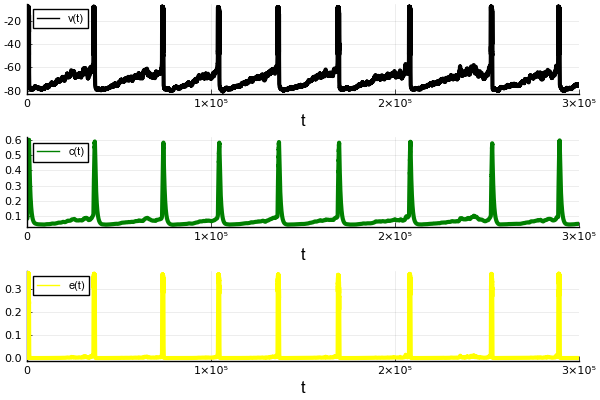

In [43]:
plot(SDEsol, vars = [:v, :c, :e], layout = grid(3,1), lw = 3, c = [:black :green :yellow])

In [45]:
tsteps = get_timesteps(SDEsol)
histogram(tsteps)
avg_timestep = sum(tsteps)/length(tsteps)
std_timestep = std(tsteps)
println("The average timestep was $(round(avg_timestep, digits = 2)) +- $(round(std_timestep, digits = 2))")
println("This is equivalent to $(round(avg_timestep * 1000, digits = 2)) Hz")

The average timestep was 1.23 +- 1.76
This is equivalent to 1227.03 Hz


### Further Documentation
- Further documentation exists in the functions included in this package. In the methods sections I will go into high detail about the equations, but unlike what I did above, I won't go into deep detail about the syntax of Julia, nor will I provide source code. Obviously this is available in the github link, and whenever possible I will state the function I used and where to find it. 
### I layout 3 chapters of explanation. 
#### Chapter 1 Methods: Explains the basics of the model and theory behind it
#### Chapter 2 Analysis: Explains data typical data analysis conducted on the output of the data
#### Chapter 3 Experiments: Compares Simulated Data to experiments conducted in the literature throughout the years 